In [1]:
import sys
import os
import h5py
import json
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

from stimuli_f0_labels import get_f0_bins, f0_to_label

fn = '/om4/group/mcdermott/user/msaddler/pitchnet_dataset/pitchnetDataset/assets/data/processed/dataset_2019-11-22-2300/PND_sr32000_v08.hdf5'
# fn = '/om4/group/mcdermott/user/msaddler/pitchnet_dataset/pitchnetDataset/assets/data/processed/dataset_2019-11-16-2300/PND_sr32000_v07.hdf5'
# fn = '/om4/group/mcdermott/user/msaddler/pitchnet_dataset/pitchnetDataset/assets/data/processed/dataset_2019-08-16-1200/PND_sr32000_v04.hdf5'

f = h5py.File(fn, 'r')
for v in f.values():
    print(v)
for v in f['config'].values():
    print(v)

file_indexes = f['source_file_index'][:]
segment_indexes = f['source_file_row'][:]
f0_values = f['nopad_f0_mean'][:]
source_file_encoding_dict = f['config/source_file_encoding_dict'][0]
source_file_encoding_dict = source_file_encoding_dict.replace('"', '"""')
source_file_encoding_dict = source_file_encoding_dict.replace('\'', '"')
source_file_encoding_dict = json.loads(source_file_encoding_dict)

f.close()


ImportError in `dataset_util.py` No module named 'pyfftw'
<HDF5 group "/config" (2 members)>
<HDF5 dataset "nopad_end_index": shape (2100000,), type "<i8">
<HDF5 dataset "nopad_f0_mean": shape (2100000,), type "<f4">
<HDF5 dataset "nopad_f0_median": shape (2100000,), type "<f4">
<HDF5 dataset "nopad_f0_percent_mean_median_difference": shape (2100000,), type "<f8">
<HDF5 dataset "nopad_f0_percent_stddev": shape (2100000,), type "<f8">
<HDF5 dataset "nopad_f0_stddev": shape (2100000,), type "<f4">
<HDF5 dataset "nopad_periodicity_mean": shape (2100000,), type "<f4">
<HDF5 dataset "nopad_periodicity_median": shape (2100000,), type "<f4">
<HDF5 dataset "nopad_periodicity_stddev": shape (2100000,), type "<f4">
<HDF5 dataset "nopad_start_index": shape (2100000,), type "<i8">
<HDF5 dataset "parent_index": shape (2100000,), type "<i8">
<HDF5 dataset "segment_end_index": shape (2100000,), type "<i8">
<HDF5 dataset "segment_source_index": shape (2100000,), type "<i8">
<HDF5 dataset "segment_star

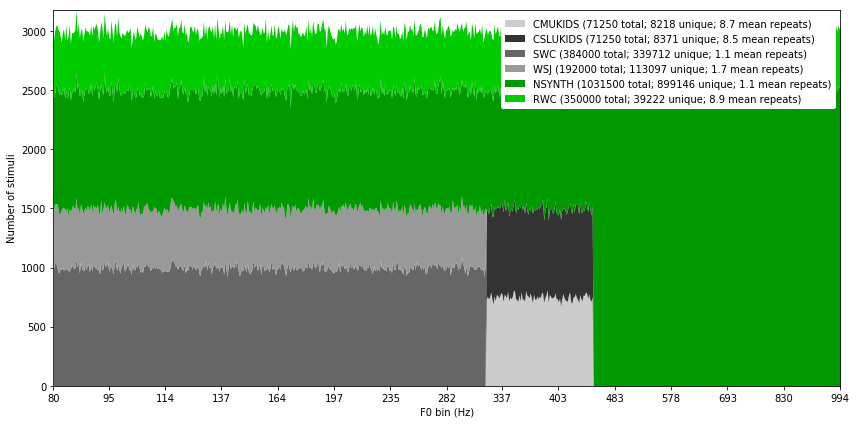

/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_12_05_PNDv08_archSearch01/2019NOV27_PND_v08_dataset_composition.pdf


In [3]:
file_index_to_filename_map = {}
for key in source_file_encoding_dict.keys():
    file_index_to_filename_map[source_file_encoding_dict[key]] = os.path.basename(key)


f0_bins = get_f0_bins()
dataset_separated_histograms = {}
dataset_separated_unique_segments = {}
dataset_separated_total_segments = {}

for file_index in np.unique(file_indexes):
    f0_values_from_file_idx = f0_values[file_indexes == file_index]
    segment_indexes_from_file_idx = segment_indexes[file_indexes == file_index]
    counts, bins = np.histogram(f0_values_from_file_idx, bins=f0_bins)
    dset_key = file_index_to_filename_map[file_index]
    dataset_separated_histograms[dset_key] = counts
    dataset_separated_unique_segments[dset_key] = np.unique(segment_indexes_from_file_idx).shape[0]
    dataset_separated_total_segments[dset_key] = segment_indexes_from_file_idx.shape[0]

dataset_details = {
    'RWC': {
        'key': 'f0_segments_2019AUG16_rwc.hdf5',
        'plot_kwargs': {'color': [0, 0.8, 0]},
    },
    'NSYNTH': {
        'key': 'f0_segments_2019AUG16_nsynth.hdf5',
        'plot_kwargs': {'color': [0, 0.6, 0]}
    },
    'WSJ': {
        'key': 'f0_segments_2019AUG16_wsj.hdf5',
        'plot_kwargs': {'color': [0.6, 0.6, 0.6]}
    },
    'SWC': {
        'key': 'f0_segments_2019AUG16_swc.hdf5',
        'plot_kwargs': {'color': [0.4, 0.4, 0.4]}
    },
    'CSLUKIDS': {
        'key': 'f0_segments_2019NOV16_cslu_kids.hdf5',
        'plot_kwargs': {'color': [0.2, 0.2, 0.2]}
    },
    'CMUKIDS': {
        'key': 'f0_segments_2019NOV22_cmu_kids.hdf5',
        'plot_kwargs': {'color': [0.8, 0.8, 0.8]}
    },
}

dataset_list = ['RWC', 'NSYNTH', 'WSJ', 'SWC', 'CSLUKIDS', 'CMUKIDS']
dataset_list.reverse()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x = np.arange(0, len(counts))
bottom = np.zeros_like(x)
for dataset in dataset_list:
    key = dataset_details[dataset]['key']
    if key in dataset_separated_histograms.keys():
        y = dataset_separated_histograms[key]
        plot_kwargs = dataset_details[dataset]['plot_kwargs']
        label = '{:s} ({} total; {} unique; {:.1f} mean repeats)'.format(
            dataset,
            dataset_separated_total_segments[key],
            dataset_separated_unique_segments[key],
            dataset_separated_total_segments[key] / dataset_separated_unique_segments[key])
        ax.fill_between(x, y1=bottom, y2=bottom+y, **plot_kwargs, lw=0, label=label)
        bottom = bottom + y
    else:
        print(key)

ax.legend(loc='upper right', framealpha=1, facecolor='w', edgecolor='w', fontsize=10)
ax.set_xlim([x[0], x[-1]])
ax.set_ylim([0, np.max(bottom)])
ax.set_ylabel('Number of stimuli')
ax.set_xlabel('F0 bin (Hz)')
class_indexes = np.linspace(x[0], x[-1], 15, dtype=int)
f0_class_labels = ['{:.0f}'.format(_) for _ in f0_bins[class_indexes]]
ax.set_xticks(class_indexes)
ax.set_xticklabels(f0_class_labels)
plt.tight_layout()
plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_12_05_PNDv08_archSearch01/'
# save_fn = '2019NOV27_PND_v08_dataset_composition.pdf'
# print(os.path.join(save_dir, save_fn))
# fig.savefig(os.path.join(save_dir, save_fn), bbox_inches='tight')


In [ ]:
import sys
import os
import json
import numpy as np
import glob

%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import stimuli_util

from stimuli_generate_synthetic_tones import get_bandpass_filter_frequency_response
from stimuli_generate_synthetic_tones import bernoxMovingFilter_bandpass_complex_tone
from stimuli_generate_synthetic_tones import generate_bernoxMovingFilter_dataset

f0 = 300
fs = 32000
dur = 0.150
low_harm = 30


frequency_response_in_dB = get_bandpass_filter_frequency_response(2.5e3, 3.5e3, fs=fs, order=4)
y, harms = bernoxMovingFilter_bandpass_complex_tone(f0, fs, dur, low_harm,
                                                    frequency_response_in_dB=frequency_response_in_dB,
                                                    threshold_dBSPL=33.3, component_dBSL=15.)
noise = stimuli_util.modified_uniform_masking_noise(fs, dur, dBHzSPL=15,
                                                    attenuation_start=600,
                                                    attenuation_slope=2)
y = noise + y
plt.figure()
plt.plot(y)
plt.show()


fxx, pxx = stimuli_util.power_spectrum(y, fs)
plt.figure(figsize=(15, 5))
plt.plot(fxx, pxx)
# plt.xlim([harms[0]-2, harms[-1]+2])
plt.show()

ipd.display(ipd.Audio(y, rate=fs))


In [ ]:
import numpy as np

f0_min=80.
f0_max=1e3
step_size_in_octaves=1/(12*16*64)
phase_modes=['sine', 'rand']
    
phase_mode_encoding = {'sine':0, 'rand':1, 'sch':2, 'cos':3, 'alt':4}
phase_mode_decoding = {0:'sine', 1:'rand', 2:'sch', 3:'cos', 4:'alt'}
# Determine list of f0 and phase values
f0s = np.arange(0, np.log2(f0_max / f0_min), step_size_in_octaves)
f0s = f0_min * (np.power(2, f0s))
f0_list = np.tile(f0s, len(phase_modes))
phase_list = []
for phase in phase_modes:
    phase_list.append(phase_mode_encoding[phase] * np.ones_like(f0s))
phase_list = np.concatenate(phase_list, axis=0)
N = f0_list.shape[0]
print(N, 12*16)

FDB =np.log10(0)
threshold_dBSPL=33.3
component_dBSL=15.
harmonic_dBSPL = threshold_dBSPL + component_dBSL + FDB
amplitudes = 20e-6 * np.power(10, (harmonic_dBSPL/20))
amplitudes, harmonic_dBSPL

In [ ]:
import h5py
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import stimuli_util

fn = '/om/user/msaddler/data_pitchnet/bernox2005/MovingFilter_f0min100_f0max300/MovingFilter_f0min100_f0max300.hdf5'
fn = 'test.hdf5'
f = h5py.File(fn, 'r')
fsig = f['tone_in_noise']
idx = np.random.randint(2600)#fsig.shape[0])

y = fsig[idx]
fs = f['config_tone/fs'][0]

f0 = f['f0'][idx]
base_f0 = f['base_f0'][idx]
low_harm = f['low_harm'][idx]
min_harm = f['min_audible_harm'][idx]
max_harm = f['max_audible_harm'][idx]
phase_mode = f['phase_mode'][idx]

print('F0={}, LOW_HARM={}, MIN_HARM={}, MAX_HARM={}, PHASE_MODE={}'.format(f0, low_harm, min_harm, max_harm, phase_mode))

plt.figure(figsize=(10, 3))
plt.plot(y)
plt.show()

plt.figure(figsize=(10, 3))
fxx, pxx = stimuli_util.power_spectrum(y, fs)
plt.plot(fxx, pxx)

fidx = np.logical_and(fxx >= low_harm*f0, fxx <= max_harm*f0)
plt.plot(fxx[fidx], pxx[fidx], 'y')

fidx = np.logical_and(fxx >= min_harm*f0, fxx <= max_harm*f0)
plt.plot(fxx[fidx], pxx[fidx], 'r')

plt.show()

f.close()

ipd.display(ipd.Audio(y, rate=fs))

In [ ]:
import sys
import os
import json
import numpy as np
import glob

%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import stimuli_util

from stimuli_generate_synthetic_tones import get_bandpass_filter_frequency_response
from stimuli_generate_synthetic_tones import shift_bandpass_filter_frequency_response

fs=32e3
dur=0.150

threshold_dBSPL=33.3
component_dBSL=15.
noise_dBHzSPL=15.
noise_attenuation_start=600.
noise_attenuation_slope=2

# Build the unmodified Bernstein & Oxenham (2005) filter frequency response function
highpass_filter_cutoff=2.5e3*2
lowpass_filter_cutoff=3.5e3*2
filter_order=4
frequency_response_in_dB = get_bandpass_filter_frequency_response(highpass_filter_cutoff,
                                                                  lowpass_filter_cutoff,
                                                                  fs=fs,
                                                                  order=filter_order)

# Define lists of f0 and lowest harmonic number values of interest
f0_min=100.
f0_max=300.
step_size_in_octaves=2/12
phase_modes=['sine', 'rand']
low_harm_min=1
low_harm_max=30
base_low_harm_numbers = np.arange(low_harm_min, low_harm_max + 1)
base_f0s = np.arange(0, np.log2(f0_max / f0_min), step_size_in_octaves)
base_f0s = f0_min * (np.power(2, base_f0s))
print(len(base_f0s) * len(base_low_harm_numbers) * len(phase_modes))

# For each pair of base f0 and base low_harm, shift the filter
def get_valid_f0_range(frequency_response_in_dB, minimum_gain, low_harm, fs=32e3):
    freq_vector = np.arange(0, fs/2)
    gain_vector = frequency_response_in_dB(freq_vector)
    passed_freqs = freq_vector[gain_vector > minimum_gain]
    fl = np.min(passed_freqs)
    fh = np.max(passed_freqs)
    
    min_f0 = fl / low_harm
    if low_harm > 1: max_f0 = fl / (low_harm - 1)
    else: max_f0 = fh / low_harm
    return [min_f0, max_f0]


def compute_low_harm(f0, frequency_response_in_dB, minimum_gain, fs=32e3):
    harm_freqs = np.arange(f0, fs/2, f0)
    harm_nums = np.array(harm_freqs / f0).astype(int)
    harm_gain = frequency_response_in_dB(harm_freqs)
    return np.min(harm_nums[harm_gain > minimum_gain])
    

f0_test_range = np.array([0.925, 1.075])
filter_counter = 0
for base_lh in base_low_harm_numbers:
    for base_f0 in base_f0s:
        filter_counter += 1
        desired_fl = base_lh * base_f0
        desired_fl_gain_in_dB = -1 * component_dBSL
#         print(filter_counter, base_lh, base_f0, desired_fl)
        
        new_freq_resp = shift_bandpass_filter_frequency_response(desired_fl, desired_fl_gain_in_dB,
                                                                 fs=fs, unshifted_passband=None,
                                                                 frequency_response_in_dB=frequency_response_in_dB)
        lhtmp_range = []
        f0tmp_range = []
        for f0tmp in base_f0*f0_test_range:
            lhtmp = compute_low_harm(f0tmp, new_freq_resp, desired_fl_gain_in_dB, fs=fs)
            lhtmp_range.append(lhtmp)
            f0tmp_range.append(f0tmp)
        
        print(base_lh, int(base_f0), f0tmp_range, lhtmp_range)
        
#         f0_range = get_valid_f0_range(new_freq_resp, desired_fl_gain_in_dB, base_lh, fs=fs)
        
#         f0_range = 100*np.array(f0_range)/base_f0
        
#         print(base_lh, int(base_f0), f0_range.astype(int))
        


plt.figure()
fr = np.arange(0, fs/2)
plt.plot(fr, frequency_response_in_dB(fr))
plt.ylim([-15, 0])
plt.show()

In [ ]:
def compute_low_harm(f0, frequency_response_in_dB, minimum_gain, fs=32e3):
    harm_freqs = np.arange(f0, fs/2, f0)
    harm_nums = np.array(harm_freqs / f0).astype(int)
    harm_gain = frequency_response_in_dB(harm_freqs)
    return np.min(harm_nums[harm_gain > minimum_gain])
    
compute_low_harm(600, frequency_response_in_dB, -15, fs=fs)

In [ ]:
base_f0_min=100.
base_f0_max=300.

np.power(2, np.linspace(np.log2(base_f0_min), np.log2(base_f0_max), 20))

delta_f0_range = [0.925, 1.075]
delta_f0_n = 101

z = 150*np.linspace(delta_f0_range[0], delta_f0_range[1], delta_f0_n)

percent_diffs = []
for tmp1 in z:
    for tmp2 in z:
        percent_diffs.append(100*np.abs(tmp1 - tmp2)/tmp2)

plt.figure()
plt.hist(percent_diffs)
plt.show()

In [ ]:
def generate_BernsteinOxenhamFixedFilter_dataset(hdf5_filename, fs=32e3, dur=0.150, phase_modes=['sine', 'rand'],
                                                 low_harm_min=1, low_harm_max=30,
                                                 base_f0_min=100.0, base_f0_max=300.0, base_f0_n=12,
                                                 delta_f0_min=0.925, delta_f0_max=1.075, delta_f0_n=101,
                                                 highpass_filter_cutoff=2.5e3, lowpass_filter_cutoff=3.5e3,
                                                 filter_order=4, threshold_dBSPL=33.3, component_dBSL=15.,
                                                 noise_dBHzSPL=15., noise_attenuation_start=600.,
                                                 noise_attenuation_slope=2, disp_step=100):
    '''
    '''
    # Define encoding / decoding dictionaries for phase_mode
    phase_mode_encoding = {'sine':0, 'rand':1, 'sch':2, 'cos':3, 'alt':4}
    phase_mode_decoding = {0:'sine', 1:'rand', 2:'sch', 3:'cos', 4:'alt'}
    # Define lists of unique phase modes and low harm numbers
    unique_ph_list = np.array([phase_mode_encoding[p] for p in phase_modes])
    unique_lh_list = np.arange(low_harm_min, low_harm_max + 1)
    # Define list of "base f0" values (Hz), which are used to set the filters
    base_f0_list = np.power(2, np.linspace(np.log2(base_f0_min), np.log2(base_f0_max), base_f0_n))
    # Define list of "delta f0" values (fraction of f0)
    delta_f0_list = np.linspace(delta_f0_min, delta_f0_max, delta_f0_n)
    # Compute number of stimuli (all combinations of low_harm, base_f0, delta_f0, and phase_mode)
    N = len(unique_ph_list) * len(unique_lh_list) * len(base_f0_list) * len(delta_f0_list)
    # Calculate the "unshifted" bandpass filter frequency response function to use as a baseline
    baseline_freq_response = get_bandpass_filter_frequency_response(highpass_filter_cutoff,
                                                                    lowpass_filter_cutoff,
                                                                    fs=fs, order=filter_order)
    # Prepare data_dict and config_key_pair_list for hdf5 filewriting
    data_dict = {
        'config_tone/fs': fs,
        'config_tone/dur': dur,
        'config_tone/low_harm_min': low_harm_min,
        'config_tone/low_harm_max': low_harm_max,
        'config_tone/base_f0_min': base_f0_min,
        'config_tone/base_f0_max': base_f0_max,
        'config_tone/base_f0_n': base_f0_n,
        'config_tone/delta_f0_min': delta_f0_min,
        'config_tone/delta_f0_max': delta_f0_max,
        'config_tone/delta_f0_n': delta_f0_n,
        'config_tone/unshifted_highpass_filter_cutoff': highpass_filter_cutoff,
        'config_tone/unshifted_lowpass_filter_cutoff': lowpass_filter_cutoff,
        'config_tone/unshifted_filter_order': filter_order,
        'config_tone/threshold_dBSPL': threshold_dBSPL,
        'config_tone/component_dBSL': component_dBSL,
        'config_tone/noise_dBHzSPL': noise_dBHzSPL,
        'config_tone/noise_attenuation_start': noise_attenuation_start,
        'config_tone/noise_attenuation_slope': noise_attenuation_slope,
    }
    config_key_pair_list = [(k, k) for k in data_dict.keys()]
    data_key_pair_list = [] # Will be populated right before initializing hdf5 file
    # Main loop to generate the bandpass filtered tones
    itrN = 0
    for lh in unique_lh_list:
        for base_f0 in base_f0_list:
            # Compute fixed filter's frequency response using low harm number and base_f0
            desired_fl = base_f0 * low_harm
            desired_fl_gain_in_dB = -1 * component_dBSL
            fixed_freq_response = shift_bandpass_filter_frequency_response(
                desired_fl, desired_fl_gain_in_dB, fs=fs, unshifted_passband=None,
                frequency_response_in_dB=baseline_freq_response)
            for delta_f0 in delta_f0_list:
                for ph in unique_ph_list:
                    # Construct signal with specified f0 and phase mode
                    f0 = base_f0 * delta_f0
                    signal, audible_harmonic_numbers = bernox2005_bandpass_complex_tone(
                        f0, fs, dur, frequency_response_in_dB=fixed_freq_response,
                        threshold_dBSPL=threshold_dBSPL, component_dBSL=component_dBSL,
                        phase_mode=phase_mode_decoding[ph])
                    # Construct modified uniform masking noise
                    noise = stimuli_util.modified_uniform_masking_noise(
                        fs, dur, dBHzSPL=noise_dBHzSPL,
                        attenuation_start=noise_attenuation_start,
                        attenuation_slope=noise_attenuation_slope)
                    # Add signal + noise and metadata to data_dict for hdf5 filewriting
                    tone_in_noise = signal + noise
                    data_dict['tone_in_noise'] = tone_in_noise.astype(np.float32)
                    data_dict['f0'] = f0
                    data_dict['base_f0'] = base_f0
                    data_dict['delta_f0'] = delta_f0
                    data_dict['phase_mode'] = int(ph)
                    data_dict['low_harm'] = int(lh)
                    data_dict['min_audible_harm'] = int(np.min(audible_harmonic_numbers))
                    data_dict['max_audible_harm'] = int(np.max(audible_harmonic_numbers))
                    # Initialize the hdf5 file on the first iteration
                    if itrN == 0:
                        print('[INITIALIZING]: {}'.format(hdf5_filename))
                        for k in data_dict.keys():
                            if not (k, k) in config_key_pair_list:
                                data_key_pair_list.append((k, k))
                        initialize_hdf5_file(hdf5_filename, N, data_dict, file_mode='w',
                                             data_key_pair_list=data_key_pair_list,
                                             config_key_pair_list=config_key_pair_list)
                        hdf5_f = h5py.File(hdf5_filename, 'r+')
                    # Write each data_dict to hdf5 file
                    write_example_to_hdf5(hdf5_f, data_dict, itrN,
                                          data_key_pair_list=data_key_pair_list)
                    if itrN % disp_step == 0:
                        print('... signal {} of {}'.format(itrN, N))
                    itrN += 1
    # Close hdf5 file
    hdf5_f.close()
    print('[END]: {}'.format(hdf5_filename))

generate_BernsteinOxenhamFixedFilter_dataset('')

In [ ]:

base_f0_min=100.0
base_f0_max=300.0
base_f0_n=10

delta_f0_min=0.94
delta_f0_max=1.06
delta_f0_n=121

base_f0_list = np.power(2, np.linspace(np.log2(base_f0_min), np.log2(base_f0_max), base_f0_n))
delta_f0_list = np.linspace(delta_f0_min, delta_f0_max, delta_f0_n)

f0_list = []
for bf0 in base_f0_list:
    for df0 in delta_f0_list:
        f0_list.append(bf0*df0)
plt.figure(figsize=(15, 10))
plt.plot(f0_list, '.')
plt.show()

delta_f0_list
# base_f0_list

In [ ]:
import numpy as np
# Define stimulus-specific parameters
list_f_carrier = [0.0, 4000.0, 6350.0, 10080.0]
f0_min=80.
f0_max=320.
step_size_in_octaves=1/(12*16*16)
f0s = np.arange(0, np.log2(f0_max / f0_min), step_size_in_octaves)
f0s = f0_min * (np.power(2, f0s))
list_f_envelope = list(f0s)

# Iterate over all combinations of stimulus-specific parameters
N = len(list_f_carrier) * len(list_f_envelope)
N

In [ ]:
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import stimuli_util

fn = 'test.hdf5'
f = h5py.File(fn, 'r')
fsig = f['tone_in_noise']

for _ in range(20):
    idx = np.random.randint(fsig.shape[0])

    y = fsig[idx]
    fs = f['config_tone/fs'][0]

    f0 = f['f0'][idx]
    filter_fl = f['filter_fl'][idx]
    phase_mode = f['phase_mode'][idx]

#     print('F0={}, filter_fl={}, PHASE_MODE={}'.format(f0, filter_fl, phase_mode))

#     plt.figure(figsize=(10, 3))
#     plt.plot(y)
#     plt.show()

    plt.figure(figsize=(10, 3))
    fxx, pxx = stimuli_util.power_spectrum(y, fs)
    plt.plot(fxx, pxx)

    plt.show()

f.close()

ipd.display(ipd.Audio(y, rate=fs))

print(20*np.log10(stimuli_util.rms(y)/20e-6))

In [ ]:
import sys
import os

import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import stimuli_util

fn_dir = '/om/user/msaddler/data_pitchnet/'

fn = os.path.join(fn_dir, 'bernox2005/FixedFilter_f0min100_f0max300/FixedFilter_f0min100_f0max300.hdf5')
f = h5py.File(fn, 'r')

signal_key = 'tone_in_noise'
sr = 32000
vals_f0 = f['f0'][:]
vals_lharm = f['low_harm'][:]
vals_phase = f['phase_mode'][:]

IDX = np.logical_and(vals_phase == 0, vals_lharm == 5)
IDX = np.logical_and(IDX, np.logical_and(vals_f0>=200, vals_f0<200.2))
IDX = np.squeeze(np.argwhere(IDX))
print(IDX)

fontsize=18
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 1.4))
cx = 0.6
COLOR_LIST = [[cx, cx, cx], [0, 0, 0]]

IDX = 11622#47920#64860
for cidx, IDX in enumerate([11620]):#, 64860]):
    y = f[signal_key][IDX]
    f0 = vals_f0[IDX]
    fxx, pxx  = stimuli_util.power_spectrum(y, sr)

    plot_kwargs = {'lw':4, 'color':COLOR_LIST[cidx]}
    ax.plot(fxx/f0, pxx, **plot_kwargs)
    
    print('F0={}, low_harm={}'.format(vals_f0[IDX], vals_lharm[IDX]))

ax.set_xlim([0, 50.5])
ax.set_ylim([16, 44])
ax.set_xticks(np.arange(0, 50, 5))
# ax.set_yticks(np.arange(0, 45, 15))
ax.tick_params(axis='both', labelsize=fontsize-2)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlabel('Harmonic number (frequency / F0)', fontsize=fontsize)
ax.set_ylabel('dB/Hz SPL', fontsize=fontsize)
plt.show()

# fig.savefig('../assets_psychophysics/figures/bernox_spectrum_pitch250_lharm05.pdf', bbox_inches='tight')


IDX = 47920+12
y = f[signal_key][IDX]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 1.5))
plot_kwargs = {'lw':2, 'color':'k'}
n = 400
offset=110
ax.plot(y[offset:offset+n], **plot_kwargs)
ax.set_xlim([0, n])
ax.set_xticks([])
ax.set_yticks([])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.show()

# fig.savefig('../assets_psychophysics/figures/bernox_waveform_lharm20_pitch250_sine.pdf', bbox_inches='tight')

f.close()


In [ ]:
import sys
import os

import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import stimuli_util

fn_dir = '/om/user/msaddler/data_pitchnet/'

fn = os.path.join(fn_dir, 'mooremoore2003/MooreMoore2003_frequencyShiftedComplexes_f0_080to480Hz/MooreMoore2003_frequencyShiftedComplexes_f0_080to480Hz.hdf5')
f = h5py.File(fn, 'r')

signal_key = 'stimuli/signal'
sr = 32000
vals_f0 = f['f0'][:]
vals_harm_cent = f['spectral_envelope_centered_harmonic'][:]
vals_f0_shift = f['f0_shift'][:]

IDX = np.logical_and(np.logical_or(vals_f0_shift == 0.0, vals_f0_shift == 0.24), vals_harm_cent == 11)
IDX = np.logical_and(IDX, np.logical_and(vals_f0>=200, vals_f0<200.1))
IDX = np.squeeze(np.argwhere(IDX))
print(IDX)


fontsize=18
cx = 0.80
plot_dict = {
    'preshift_RES': {'IDX_LIST': [14217], 'COLOR_LIST': [[1, 0, 0]]},
    'preshift_INT': {'IDX_LIST': [42014], 'COLOR_LIST': [[0, 0, 1]]},
    'preshift_UNRES': {'IDX_LIST': [69811], 'COLOR_LIST': [[0, 0, 0]]},
    
    'postshift_RES': {'IDX_LIST': [14217, 14223], 'COLOR_LIST': [[1, cx, cx], [1, 0, 0]]},
    'postshift_INT': {'IDX_LIST': [42014, 42020], 'COLOR_LIST': [[cx, cx, 1], [0, 0, 1]]},
    'postshift_UNRES': {'IDX_LIST': [69811, 69817], 'COLOR_LIST': [[cx, cx, cx], [0, 0, 0]]}
}

save_fn_pattern = '../assets_psychophysics/figures/freqshift_spectrum_{}.pdf'

for key in plot_dict.keys():    
    IDX_LIST = plot_dict[key]['IDX_LIST']
    COLOR_LIST = plot_dict[key]['COLOR_LIST']

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 1.25))
    for cidx, IDX in enumerate(IDX_LIST):
        y = f[signal_key][IDX]
        f0 = vals_f0[IDX]
        fxx, pxx  = stimuli_util.power_spectrum(y, sr)

        plot_kwargs = {'lw':3, 'color':COLOR_LIST[cidx]}
        ax.plot(fxx/f0, pxx, **plot_kwargs)

    ax.set_xlim([0, 20])
    ax.set_ylim([25, 55])
    ax.set_xticks(np.arange(0, 21, 2))
    # ax.set_yticks(np.arange(0, 45, 15))
    ax.tick_params(axis='both', labelsize=fontsize-2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.set_xlabel('Harmonic number (frequency / F0)', fontsize=fontsize)
    ax.set_ylabel('dB/Hz SPL', fontsize=fontsize)

    plt.show()
    print(save_fn_pattern.format(key))
#     fig.savefig(save_fn_pattern.format(key), bbox_inches='tight')

f.close()


In [ ]:
import sys
import os

import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import stimuli_util

fn_dir = '/om/user/msaddler/data_pitchnet/'

fn = os.path.join(fn_dir, 'moore1985/Moore1985_MistunedHarmonics_v00/Moore1985_MistunedHarmonics_v00.hdf5')
f = h5py.File(fn, 'r')

for v in f.values():
    print(v)

signal_key = 'stimuli/signal'
sr = 32000
vals_f0 = f['f0'][:]
vals_mistuned_harm = f['mistuned_harm'][:]
vals_mistuned_pct = f['mistuned_pct'][:]

IDX = np.logical_and(np.logical_or(vals_mistuned_pct == 0.0, vals_mistuned_pct == 4.0), vals_mistuned_harm == 2)
IDX = np.logical_and(IDX, np.logical_and(vals_f0>=200, vals_f0<200.1))
IDX = np.squeeze(np.argwhere(IDX))
print(IDX)



fontsize=18
cx = 0.80
plot_dict = {
    'preshift_200Hz_mistuned0pct': {'IDX_LIST': [31775], 'COLOR_LIST': [[0, 0, 0]]},
    'postshift_200Hz_mistuned4pct_harm2': {'IDX_LIST': [31775, 15755], 'COLOR_LIST': [[cx, cx, cx], [0, 0, 0]]},
    'postshift_200Hz_mistuned4pct_harm4': {'IDX_LIST': [31775, 33911], 'COLOR_LIST': [[cx, cx, cx], [0, 0, 0]]},
    'postshift_200Hz_mistuned4pct_harm6': {'IDX_LIST': [31775, 52067], 'COLOR_LIST': [[cx, cx, cx], [0, 0, 0]]},
}

save_fn_pattern = '../assets_psychophysics/figures/mistunedharmonics_spectrum_{}.pdf'

for key in sorted(plot_dict.keys()):    
    IDX_LIST = plot_dict[key]['IDX_LIST']
    COLOR_LIST = plot_dict[key]['COLOR_LIST']

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 1.5))
    for cidx, IDX in enumerate(IDX_LIST):
        y = f[signal_key][IDX]
        f0 = vals_f0[IDX]
        fxx, pxx  = stimuli_util.power_spectrum(y, sr)

        plot_kwargs = {'lw':3, 'color':COLOR_LIST[cidx]}
        ax.plot(fxx/f0, pxx, **plot_kwargs)

    ax.set_xlim([0, 13])
    ax.set_ylim([25, 55])
    ax.set_xticks(np.arange(0, 13, 2))
    # ax.set_yticks(np.arange(0, 45, 15))
    ax.tick_params(axis='both', labelsize=fontsize-2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.set_xlabel('Harmonic number (frequency / F0)', fontsize=fontsize)
    ax.set_ylabel('dB/Hz SPL', fontsize=fontsize)

    plt.show()
    print(save_fn_pattern.format(key))
#     fig.savefig(save_fn_pattern.format(key), bbox_inches='tight')

f.close()


In [ ]:
import sys
sys.path.append('/om4/group/mcdermott/user/msaddler/pitchnet_dataset/pitchnetDataset/pitchnetDataset')
from dataset_util import get_f0_bins, f0_to_label, f0_to_octave, f0_to_normalized
from dataset_util import label_to_f0, octave_to_f0, normalized_to_f0

In [ ]:
x = get_f0_bins()

(x[1]-x[0]) / x[1]

# x[0], x[1]

In [ ]:
1/0.062499999999998744

In [ ]:
import os
import sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import glob
import h5py
import IPython.display as ipd

from stimuli_generate_BernsteinOxenhamFixedFilter import *

fs=32000
dur = 0.5

phase_mode = 'sine'

highpass_filter_cutoff=2.5e3
lowpass_filter_cutoff=3.5e3
filter_order=4
threshold_dBSPL=33.3
component_dBSL=15.0
noise_dBHzSPL=15.0
noise_attenuation_start=600.0
noise_attenuation_slope=2



diff = 1.03
(f0_1, f0_2) = (150, 150*diff)
base_f0 = 150
lh = 28
nrep = 1
padlen = int(fs/10)
pin = np.array([])

baseline_freq_response = get_bandpass_filter_frequency_response(highpass_filter_cutoff,
                                                                lowpass_filter_cutoff,
                                                                fs=fs, order=filter_order)
desired_fl = base_f0 * lh
desired_fl_gain_in_dB = -1 * component_dBSL
fixed_freq_response = shift_bandpass_filter_frequency_response(
    desired_fl, desired_fl_gain_in_dB, fs=fs, unshifted_passband=None,
    frequency_response_in_dB=baseline_freq_response)

for _ in range(nrep):
    signal_1, audible_harmonic_numbers = bernox2005_bandpass_complex_tone(
        f0_1, fs, dur, frequency_response_in_dB=fixed_freq_response,
        threshold_dBSPL=threshold_dBSPL, component_dBSL=component_dBSL,
        phase_mode=phase_mode)
    signal_1 = np.pad(signal_1, (padlen, padlen), 'constant', constant_values=(0, 0))
    
    signal_2, audible_harmonic_numbers = bernox2005_bandpass_complex_tone(
        f0_2, fs, dur, frequency_response_in_dB=fixed_freq_response,
        threshold_dBSPL=threshold_dBSPL, component_dBSL=component_dBSL,
        phase_mode=phase_mode)
    signal_2 = np.pad(signal_2, (padlen, padlen), 'constant', constant_values=(0, 0))
    
    pin = np.append(pin, signal_1, axis=0)
    pin = np.append(pin, signal_2, axis=0)
# # Construct modified uniform masking noise
# noise = stimuli_util.modified_uniform_masking_noise(
#     fs, dur, dBHzSPL=noise_dBHzSPL,
#     attenuation_start=noise_attenuation_start,
#     attenuation_slope=noise_attenuation_slope)

print(lh, f0_1, f0_2, base_f0)
ipd.display(ipd.Audio(pin, rate=fs))

# fn_out = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_01_cog_lunch_figures/bernox_demo_lharm28_sine_150Hz_3pct.wav'
# print(fn_out)
# import scipy.io.wavfile
# scipy.io.wavfile.write(fn_out, fs, np.squeeze(pin))

In [ ]:
import sys
import os

import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import stimuli_util
sys.path.append('/code_location/multi_gpu')
import functions_erbfilter as erb


sr = 32000
n = 40
signal_length = 4800
min_cf = 125
max_cf = 14000
bandwidth_scale_factor = 1.0
filts, cfs, freqs = erb.make_roex_filters(signal_length, sr, n,  min_cf=min_cf, max_cf=max_cf,
                                          bandwidth_scale_factor=bandwidth_scale_factor,
                                          padding_size=None, full_filter=False, dc_ramp_cutoff=30)
filts = 20*np.log10(filts)



ylimits = [18, 42]
xlimits = [0, 11e3]
filts = filts + ylimits[-1] - 1

fn_dir = '/om/user/msaddler/data_pitchnet/'

fn = os.path.join(fn_dir, 'bernox2005/FixedFilter_f0min100_f0max300/FixedFilter_f0min100_f0max300.hdf5')
f = h5py.File(fn, 'r')

signal_key = 'tone_in_noise'
sr = 32000
vals_f0 = f['f0'][:]
vals_lharm = f['low_harm'][:]
vals_phase = f['phase_mode'][:]

IDX_list = []
for low_harm in [4, 27]:
    IDX = np.logical_and(vals_phase == 0, vals_lharm == low_harm)
    IDX = np.logical_and(IDX, np.logical_and(vals_f0>=200, vals_f0<200.2))
    IDX = np.squeeze(np.argwhere(IDX))
    print('low_harm={}, IDX={}'.format(low_harm, IDX))
    IDX_list.append(int(IDX))

fontsize=16
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 1.25))
cx = 0.6
COLOR_LIST = [[cx, cx, cx], [0, 0, 0]]

FILTERBANK_COLOR = [0.85, 0.9, 0.85]

for fidx in range(n):
    ax.plot(freqs, filts[:, fidx], color=FILTERBANK_COLOR, lw=2)

for cidx, IDX in enumerate(IDX_list):
    y = f[signal_key][IDX]
    f0 = vals_f0[IDX]
    fxx, pxx  = stimuli_util.power_spectrum(y, sr)

    plot_kwargs = {'lw':3, 'color':COLOR_LIST[cidx]}
    ax.plot(fxx, pxx, **plot_kwargs)
    
    print('F0={}, low_harm={}'.format(vals_f0[IDX], vals_lharm[IDX]))

ax.set_xlim(xlimits)
ax.set_ylim(ylimits)
ax.set_xticks(np.arange(xlimits[0], xlimits[1]+1, 2000), minor=False)
ax.set_xticks(np.arange(xlimits[0], xlimits[1]+1, 200), minor=True)
ax.set_yticks([20, 40])
ax.tick_params(axis='both', labelsize=fontsize-2, which='major', length=6)
ax.tick_params(axis='both', labelsize=fontsize-2, which='minor', length=3)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlabel('Frequency (Hz)', fontsize=fontsize)
ax.set_ylabel('dB/Hz SPL', fontsize=fontsize)
plt.show()

# fig.savefig('/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_17_APAN_poster/schematic_bernox_spectra_with_filterbank.pdf', bbox_inches='tight')



IDX_list = []
for phase_mode in [1, 0]:
    IDX = np.logical_and(vals_phase == phase_mode, vals_lharm == 20)
    IDX = np.logical_and(IDX, np.logical_and(vals_f0>=200, vals_f0<200.2))
    IDX = np.squeeze(np.argwhere(IDX))
    print('low_harm={}, IDX={}'.format(low_harm, IDX))
    IDX_list.append(int(IDX))

fig, ax = plt.subplots(nrows=len(IDX_list), ncols=1, figsize=(4, 2.5),
                       sharex=True, sharey=True)


n = 380
offset=155
for ax_idx, IDX in enumerate(IDX_list):
    y = f[signal_key][IDX]

    plot_kwargs = {'lw':2, 'color':'k'}
    ax[ax_idx].plot(y[offset:offset+n], **plot_kwargs)
    ax[ax_idx].set_xlim([0, n])
    ax[ax_idx].set_xticks([])
    ax[ax_idx].set_yticks([])
    ax[ax_idx].spines["top"].set_visible(False)
    ax[ax_idx].spines["right"].set_visible(False)
    ax[ax_idx].spines["bottom"].set_visible(False)
    ax[ax_idx].spines["left"].set_visible(False)
    
plt.tight_layout()
plt.show()

# fig.savefig('/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_17_APAN_poster/schematic_bernox_waveform_sine_rand_lowharm20.pdf', bbox_inches='tight')

f.close()


In [ ]:
import sys
import os

import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import stimuli_util

fn_dir = '/om/user/msaddler/data_pitchnet/'

fn = os.path.join(fn_dir, 'mooremoore2003/MooreMoore2003_frequencyShiftedComplexes_f0_080to480Hz/MooreMoore2003_frequencyShiftedComplexes_f0_080to480Hz.hdf5')
f = h5py.File(fn, 'r')

signal_key = 'stimuli/signal'
sr = 32000
vals_f0 = f['f0'][:]
vals_harm_cent = f['spectral_envelope_centered_harmonic'][:]
vals_f0_shift = f['f0_shift'][:]

# IDX = np.logical_and(np.logical_or(vals_f0_shift == 0.0, vals_f0_shift == 0.24), vals_harm_cent == 11)
# IDX = np.logical_and(IDX, np.logical_and(vals_f0>=200, vals_f0<200.1))
# IDX = np.squeeze(np.argwhere(IDX))
# print(IDX)


fontsize=20
cx = 0.75
plot_dict = {
#     'preshift_RES': {'IDX_LIST': [14217], 'COLOR_LIST': [[1, 0, 0]]},
#     'preshift_UNRES': {'IDX_LIST': [69811], 'COLOR_LIST': [[0, 0, 0]]},
    
    'postshift_RES': {'IDX_LIST': [14217, 14223], 'COLOR_LIST': [[1, cx, cx], [1, 0, 0]]},
    'postshift_UNRES': {'IDX_LIST': [69811, 69817], 'COLOR_LIST': [[cx, cx, cx], [0, 0, 0]]}
}


sr = 32000
n = 40
signal_length = 4800
min_cf = 125
max_cf = 14000
bandwidth_scale_factor = 1.0
filts, cfs, freqs = erb.make_roex_filters(signal_length, sr, n,  min_cf=min_cf, max_cf=max_cf,
                                          bandwidth_scale_factor=bandwidth_scale_factor,
                                          padding_size=None, full_filter=False, dc_ramp_cutoff=30)
filts = 20*np.log10(filts)

xlimits = [0, 4000]
ylimits = [25, 60]
filts = filts + ylimits[-1] - 1

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 1.2))

FILTERBANK_COLOR = [0.85, 0.9, 0.85]

for fidx in range(n):
    ax.plot(freqs, filts[:, fidx], color=FILTERBANK_COLOR, lw=2)

for key in plot_dict.keys():    
    IDX_LIST = plot_dict[key]['IDX_LIST']
    COLOR_LIST = plot_dict[key]['COLOR_LIST']

    for cidx, IDX in enumerate(IDX_LIST):
        y = f[signal_key][IDX]
        f0 = vals_f0[IDX]
        fxx, pxx  = stimuli_util.power_spectrum(y, sr)

        plot_kwargs = {'lw':3, 'color':COLOR_LIST[cidx]}
        ax.plot(fxx, pxx, **plot_kwargs)

ax.set_xlim(xlimits)
ax.set_ylim(ylimits)
ax.set_xticks(np.arange(xlimits[0], xlimits[1]+1, 1000), minor=False)
ax.set_xticks(np.arange(xlimits[0], xlimits[1]+1, 200), minor=True)

ax.set_yticks([30, 55])
ax.tick_params(axis='both', labelsize=fontsize-2, which='major', length=6)
ax.tick_params(axis='both', labelsize=fontsize-2, which='minor', length=3)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlabel('Frequency (Hz)', fontsize=fontsize)
ax.set_ylabel('dB/Hz SPL', fontsize=fontsize)
plt.show()

f.close()

# fig.savefig('/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_17_APAN_poster/schematic_freqshift_spectra_with_filterbank.pdf', bbox_inches='tight')


In [ ]:
import sys
import os

import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import stimuli_util

fn_dir = '/om/user/msaddler/data_pitchnet/'

fn = os.path.join(fn_dir, 'moore1985/Moore1985_MistunedHarmonics_v00/Moore1985_MistunedHarmonics_v00.hdf5')
f = h5py.File(fn, 'r')

signal_key = 'stimuli/signal'
sr = 32000
vals_f0 = f['f0'][:]
vals_mistuned_harm = f['mistuned_harm'][:]
vals_mistuned_pct = f['mistuned_pct'][:]

IDX = np.logical_and(np.logical_or(vals_mistuned_pct == 0.0, vals_mistuned_pct == 6.0), vals_mistuned_harm == 4)
IDX = np.logical_and(IDX, np.logical_and(vals_f0>=200, vals_f0<200.1))
IDX = np.squeeze(np.argwhere(IDX))
print(IDX)


fontsize=20
cx = 0.75
plot_dict = {
#     'preshift_200Hz_mistuned0pct': {'IDX_LIST': [31775], 'COLOR_LIST': [[0, 0, 0]]},
#     'postshift_200Hz_mistuned4pct_harm2': {'IDX_LIST': [31775, 15755], 'COLOR_LIST': [[cx, cx, cx], [0, 0, 0]]},
    'postshift_200Hz_mistuned6pct_harm4': {'IDX_LIST': [31775, 34979], 'COLOR_LIST': [[cx, cx, cx], [0, 0, 0]]},
#     'postshift_200Hz_mistuned4pct_harm6': {'IDX_LIST': [31775, 52067], 'COLOR_LIST': [[cx, cx, cx], [0, 0, 0]]},
}


sr = 32000
n = 40
signal_length = 4800
min_cf = 125
max_cf = 14000
bandwidth_scale_factor = 1.0
filts, cfs, freqs = erb.make_roex_filters(signal_length, sr, n,  min_cf=min_cf, max_cf=max_cf,
                                          bandwidth_scale_factor=bandwidth_scale_factor,
                                          padding_size=None, full_filter=False, dc_ramp_cutoff=30)
filts = 20*np.log10(filts)

xlimits = [0, 2600]
ylimits = [25, 55]
filts = filts + ylimits[-1] - 1

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 1.2))

FILTERBANK_COLOR = [0.85, 0.9, 0.85]

for fidx in range(n):
    ax.plot(freqs, filts[:, fidx], color=FILTERBANK_COLOR, lw=2)

for key in plot_dict.keys():    
    IDX_LIST = plot_dict[key]['IDX_LIST']
    COLOR_LIST = plot_dict[key]['COLOR_LIST']

    for cidx, IDX in enumerate(IDX_LIST):
        y = f[signal_key][IDX]
        f0 = vals_f0[IDX]
        fxx, pxx  = stimuli_util.power_spectrum(y, sr)

        plot_kwargs = {'lw':3, 'color':COLOR_LIST[cidx]}
        ax.plot(fxx, pxx, **plot_kwargs)

ax.set_xlim(xlimits)
ax.set_ylim(ylimits)
ax.set_xticks(np.arange(xlimits[0], xlimits[1]+1, 1000), minor=False)
ax.set_xticks(np.arange(xlimits[0], xlimits[1]+1, 200), minor=True)

ax.set_yticks([30, 50])
ax.tick_params(axis='both', labelsize=fontsize-2, which='major', length=6)
ax.tick_params(axis='both', labelsize=fontsize-2, which='minor', length=3)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlabel('Frequency (Hz)', fontsize=fontsize)
ax.set_ylabel('dB/Hz SPL', fontsize=fontsize)
plt.show()

f.close()

# fig.savefig('/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_17_APAN_poster/schematic_mistunedharm_spectra_with_filterbank_lowharm04_pct06.pdf', bbox_inches='tight')



In [ ]:
import sys
import os

import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import stimuli_util

t0 = 0.0159
dur = 0.021
sr = 32000
t = np.arange(t0, t0+dur, 1/sr)

stim_list = [
    (200, 'sine'),
    (200, 'alt'),
    (400, 'sine'),
]
y_list = []
for idx, (f0, phase_mode) in enumerate(stim_list):
    print(f0, phase_mode)
    signal = np.zeros_like(t)
    freq_list = f0*np.arange(1, 16)
    if phase_mode == 'alt':
        phase_list = np.pi/2 * np.ones(len(freq_list))
        phase_list[::2] = 0
    else:
        phase_list = np.zeros(len(freq_list))

    for freq, phase in zip(freq_list, phase_list):
        if freq < sr/2:
            signal = signal + np.sin(2*np.pi*freq*t + phase)

    y_list.append(signal)

fig, ax = plt.subplots(nrows=len(y_list), ncols=1, figsize=(4, 4),
                       sharex=True, sharey=True)
for ax_idx in range(len(y_list)):
    y = y_list[ax_idx]

    plot_kwargs = {'lw':2, 'color':'k'}
    ax[ax_idx].plot(y, **plot_kwargs)
    ax[ax_idx].set_xlim([0, len(y)])
    ax[ax_idx].set_xticks([])
    ax[ax_idx].set_yticks([])
    ax[ax_idx].spines["top"].set_visible(False)
    ax[ax_idx].spines["right"].set_visible(False)
    ax[ax_idx].spines["bottom"].set_visible(False)
    ax[ax_idx].spines["left"].set_visible(False)
    
plt.tight_layout()
plt.show()

# fig.savefig('/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_17_APAN_poster/schematic_altphase_waveforms_200HzF0_harm1to15.pdf', bbox_inches='tight')


In [ ]:
import sys
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
import stimuli_util

import scipy.signal

t0 = 0.0
dur = 1.000
sr = 32000
t = np.arange(t0, t0+dur, 1/sr)
y = np.random.randn(t.shape[0])
print(y.shape)

fyy, pyy = stimuli_util.power_spectrum(y, sr)

plt.figure()
plt.plot(fyy, pyy)
plt.xlim([0, 8000])
plt.show()

meanrates_fs = 16000
pin_fs = 32000
y = scipy.signal.resample_poly(y, int(meanrates_fs), int(pin_fs))
y = scipy.signal.resample_poly(y, int(pin_fs), int(meanrates_fs))

fyy, pyy = stimuli_util.power_spectrum(y, sr)

plt.figure()
plt.plot(fyy, pyy)
plt.xlim([0, 8000])
plt.show()


In [ ]:
import sys
import os
import json
import numpy as np
import glob

%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import stimuli_util


f0 = 200
fs = 32000
dur = 0.05
harmonic_numbers = np.arange(1, 21)

np.random.seed(0)
y = stimuli_util.complex_tone(f0, fs, dur, harmonic_numbers=harmonic_numbers,
                              frequencies=None, amplitudes=None, phase_mode='sine',
                              offset_start=True, strict_nyquist=True)
t = np.arange(0, y.shape[0])/fs

y = stimuli_util.set_dBSPL(y, 60)
noise = stimuli_util.modified_uniform_masking_noise(fs, dur)

y = stimuli_util.combine_signal_and_noise(y, noise, 15, rms_out=0.02)

ipd.display(ipd.Audio(y, rate=fs))

ysmall = y#[0:800]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 0.75))
plot_kwargs = {'lw':1, 'color':'k'}
ax.plot(ysmall, **plot_kwargs)
ax.set_xlim([0, len(ysmall)])
ax.set_xticks([])
ax.set_yticks([])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)

plt.tight_layout()
plt.show()
# fig.savefig('/om2/user/msaddler/pitchnet/assets_psychophysics/figures/tmp1.pdf', bbox_inches='tight')


fyy, pyy = stimuli_util.power_spectrum(y, fs)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 2.5))
fontsize_labels = 16
fontsize_ticks = 12
plot_kwargs = {'lw':1, 'color':'k'}

for harm in harmonic_numbers:
    ax.axvline(x=harm*f0, lw=0.25, color='r')#, ls='--', dashes=(2, 2))

ax.plot(fyy, pyy, **plot_kwargs)


xticks = np.arange(0, harmonic_numbers[-1]*f0+1, f0*5)
xticks_minor = np.arange(0, harmonic_numbers[-1]*f0+1, f0)
ax.set_xlim([xticks[0], xticks[-1]])
ax.set_ylim([0, 40])
ax.set_xticks(xticks)
ax.set_xticks(xticks_minor, minor=True)

ax.set_xlabel('Frequency (Hz)', fontsize=fontsize_labels)
ax.set_ylabel('dB/Hz SPL', fontsize=fontsize_labels)
ax.tick_params(axis='both', labelsize=fontsize_ticks)
ax.tick_params(axis='both', which='major', size=6)
ax.tick_params(axis='both', which='minor', size=4)

plt.tight_layout()
plt.show()
# fig.savefig('/om2/user/msaddler/pitchnet/assets_psychophysics/figures/tmp2.pdf', bbox_inches='tight')
